In [6]:
"""
Demo to show Polynomial Regression has better accuracy than Linear Regression.

Using Polynomial Regression is only need a litle bit more code.

Demo v1.0
Hariyanto Lim
Last update: 2024-04-20
"""
# require: pip install ipympl
%matplotlib widget 

import matplotlib.pylab as plt

import sys # to get arguments (parameter) manually

import pandas as pd
import numpy as np
import json

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

#from sklearn.metrics import mean_squared_error # == [(a - b) ** 2]
from sklearn.metrics import mean_absolute_error # == [abs(a - b)]


In [7]:
def save_model(model, poly, filename):
    print('### save_model()')

    # save the model and the poly to disk
    pickle.dump((model, poly), open(filename, 'wb'))

def load_model(filename):

    try:
        # load both model and poly
        model, poly = pickle.load(open(filename, 'rb'))

        print(f"### load_model(): '{filename}' loaded")

        return model, poly

    except FileNotFoundError:
        print(f"### load_model(): error '{filename}' not found")

    return None

def evaluate_model(modelLR, poly, X, y):

    if poly is None:
        # using Linear

        # predict
        y_pred = modelLR.predict(X)
    else:
        # using poly
                
        # transform X_train value to poly to make it in the same form
        X_poly = poly.transform(X)

        # predict
        y_pred = modelLR.predict(X_poly)

    """
    LEARNING POINT: after predict then check the accuracy
    """    
    # 1st check using R2 score
    a_r2_score = r2_score(y, y_pred)
    
    # 2nd check using MAE (Mean Absolute Error)
    mae = mean_absolute_error(y, y_pred)
    
    #print(f"\n### accuracy check")
    print(f"R2 score = {a_r2_score:.7f}, [closer to 1.0 is better]")
    print(f"MeanAbsoluteError = {mae:,.1f}, [close to 0.0 is better]")
    #print(f"###\n")

    """
    LEARNING POINT: to improve accuracy, we can search and remove outliers.

    NOTE: 
    1. Removing outliers is optional.
    2. IF we want to search for outlier in a dataset, we can use Interquartile Range (IQR)
       but if we want to search for outlier after prediction then this is 1 of the many ways.
    """
    find_outliers_after_prediction = True 
    if find_outliers_after_prediction:
        # change to 1D and convert to int
        y_pred = y_pred.flatten().astype(int) 

        # Use 'Threshold' as limit to compare and find outliers.
        # What 'Threshold' value is suitable? that is depend on our data!!
        threshold = 1000
        temp = find_outlier_as_table(y.flatten(), y_pred, threshold) # flatten y to 1D array

        print(f"===== Outliers table =====")
        #pd.set_option('display.max_rows', None)  # Set max_rows to None to display all rows  
        print(temp) # display to check visually

        """
        After outliers are found, analyze whether to keep or remove outliers,
        1. Sometimes outliers are useful in continuous regression.
        2. Analyze if one or more features may not have strong **Correlation**,
            so need to check and remove the feature then re-build model.
            eg: in house price prediction, the total doors and total windows
                may not have strong correlation therefore these features can be removed.
        """

    ############ end of optional #####################################

    return

def find_outlier_as_table(target, predicted, threshold):
    """
    Outlier is data point that stands out from the rest of the group.
    It's either much higher or lower than most of the other data points in the set.

    Create a DataFrame containing target, predicted, MAE, and outlier flag.
    Parameters:
    target (list or array-like): The array of actual values.
    predicted (list or array-like): The array of predicted values.
    threshold (float): The threshold value for detecting outliers.

    Returns:
    pandas.DataFrame: DataFrame containing target, predicted, MAE, and outlier flag.
    """
    # Calculate Mean Absolute Error (MAE)
    mae = [abs(t - p) for t, p in zip(target, predicted)]
    
    # Determine outliers
    outliers = [1 if error > threshold else 0 for error in mae]
    
    # Create DataFrame
    df = pd.DataFrame({
        'target': target,
        'predicted': predicted,
        'mae': mae,
        'outlier': outliers
    })
    
    return df


# function to build optimal model
def create_model(df, use_polynomial):
    """
    Main job: create model from DataFrame    
    """

    print(f"### create_model(DataFrame, {use_polynomial=})")

    # define X ==> data to train (independent) and y ==> the target (dependent, annotated)
    X = df.drop(df.columns[-1], axis=1) # df.columns[-1] == the most right side column
    y = df.take([-1], axis=1)

    """
    Optional check: data to learn (X) should be numerical (int or float), there should NOT be any blank, text, or symbol.    
    """
    numeric_df = df.apply(pd.to_numeric, errors='coerce')
    is_all_numeric = not numeric_df.isnull().values.any()
    if is_all_numeric == False:
        print(f"*** ERROR: the data content of CSV to be used as training model has non-numeric value, please fix this!")
        print(df)
        return None
    
    """
    LEARNING POINT: A common exercise to split the input data for training and for testing,
    Reasons:
    1. To evaluate the model we should not use data from other source,
       we only trust all data points from this same source.
    2. To create unseen data to get performance of the model using unseen data later.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    # create the model variable, 
    # NOTE: in scikit, Polynomial Regression also using LinearRegression
    modelLR = LinearRegression()

    if use_polynomial:
        # Polynomial regression need 'degree' parameter, so create it
        degree, poly = create_optimal_polynomial_degree(modelLR, X_train.values, y_train.values)

        #print(f"Polynomial Regression model is created with degree = {degree}")
    else:
        # using Linear Regression
        # with only values (exclude header text)
        modelLR.fit(X_train.values, y_train.values)
        poly = None # indicate it is Linear Regression

        print(f"Linear Regression model is created")

    # show the coefficient and intercept value
    print(f"***\nCoefficients = {modelLR.coef_}\nIntercept = {modelLR.intercept_}\n***")

    """
    LEARNING POINT: After model is created, it is time to use the model to predict the same trained data
    Reasons:
    1. Model assessment, predicting on the training data allows us
       to assess how well the model fits the training data.
    2. Debugging and understanding, Examining the predictions on the training data
       can help in debugging the model and understanding its behavior.
       By comparing the predicted values with the actual values in the training set,
       we can identify potential issues such as underfitting, overfitting, or data preprocessing errors.
       IF we found problem THEN we can try to update the model
    """
    print(f"\n***** Evaluate model using TRAINED data *****")
    evaluate_model(modelLR, poly, X_train.values, y_train.values)
    print(f"***** end of evaluation using trained data *****")

    """
    LEARNING POINT: After model assessment is done and the performance is accepted,
    then predict the unseen testing data.
    Reasons:
    1. Model evaluation, create unseen data to get performance of the model using unseen data later.
    2. Prevent overfitting, to check if the model is effective only on trained data but not on unseen data.    
    """
    print(f"\n***** Evaluate model using UNSEEN TESTING data *****")
    evaluate_model(modelLR, poly, X_test.values, y_test.values)
    print(f"***** end of evaluation using unseen testing data *****")

    """
    LEARNING POINT: Comparing the result of trained data and unseen data,
    if they are close then the model is good.
    if they are not close then maybe the model is overfit to the trained data
        and if the model is overfit then reduce the 'degree' value.
    """

    return modelLR, poly

def create_optimal_polynomial_degree(modelLR, X_train, y_train):
    print(f"Create optimal Polynomial degree")

    r2_score_lower_limit_threshold = 0.1
    degree_highest_r2_score = 0
    highest_r2_score = 0

    degree = 2 # NOTE: minimum Polynomial degree is 2

    a_r2_score = 0

    """
    In my experience, higher degree (ie: > 4) normally overfit,    
    the unseen data can not be predicted well.

    So we set target of lower r2_score to prevent using higher degree.
    """
    min_r2_score = 0.90 # if more than maybe overfit

    y_poly_pred = None

    # In this example, find optimal 'degree' ONLY up to 10
    while degree <= 10 and a_r2_score < min_r2_score: 
        """
        WARNING: the higher the 'degree' value, the SLOWER the prediction !!!
        """
        
        poly = PolynomialFeatures(degree=degree, include_bias=False)

        # transform X_train value to poly        
        X_train_poly = poly.fit_transform(X_train)

        # train the transformed (using PolynomialFeatures) data
        modelLR.fit(X_train_poly, y_train)

        # predict the training data to see r2_score
        y_poly_pred = modelLR.predict(X_train_poly)
        
        # NOTE: in this demo, we only use r2_score() to check the accuracy
        a_r2_score = r2_score(y_train, y_poly_pred)
        if a_r2_score < min_r2_score:
            print(f"degree = {degree} only got r2 score = {a_r2_score}")
        
        if a_r2_score > highest_r2_score:
            # save it
            highest_r2_score = a_r2_score
            degree_highest_r2_score = degree
        elif a_r2_score < highest_r2_score - r2_score_lower_limit_threshold:
            """
            IF r2_score is smaller when using higher 'degree'
            THEN it means accuracy went down
            NORMALLY it won't go up again, so break loop
            """ 
            print(f"degree={degree}'s r2 score is lower than previously, so break loop")
            break

        degree += 1 # increase trial counter

    #################################################
    # recreate the model and the poly using the degree_highest_r2_score 
    # because current model and poly may be different than HIGHEST R2 model & poly.

    poly = PolynomialFeatures(degree=degree_highest_r2_score, include_bias=False)

    # transform X_train value to poly        
    X_train_poly = poly.fit_transform(X_train)

    # train the transformed (using PolynomialFeatures) data
    modelLR.fit(X_train_poly, y_train)
    #################################################
    
    print(f"***\nFound optimal Polynomial degree = {degree_highest_r2_score}")
    print(f"Highest r2 score = {highest_r2_score}\n***")

    return degree_highest_r2_score, poly

def load_csv_into_dataframe(csv_filename):
    try:
        df = pd.read_csv(csv_filename)

        return df

    except FileNotFoundError:
        print(f"*** load_csv_into_dataframe(): '{csv_filename}' not found")

    return None

In [8]:
#input_filename = "house_price_30_all_numerical.csv"
input_filename = "random_polynomial_house_prices.csv"

df = load_csv_into_dataframe(input_filename)
if df is None:
    print(f"load csv '{input_filename}' failed")
    exit(-3)

# display data to verify content
print(df)

    Size (m²)  Age (years)  Price
0          30           10   4718
1          31           10   5078
2          32            4   6001
3          33            7   6220
4          33            8   6120
..        ...          ...    ...
95         97           10  54903
96         98            9  56213
97         99            2  57800
98         99            4  57767
99         99            9  57374

[100 rows x 3 columns]


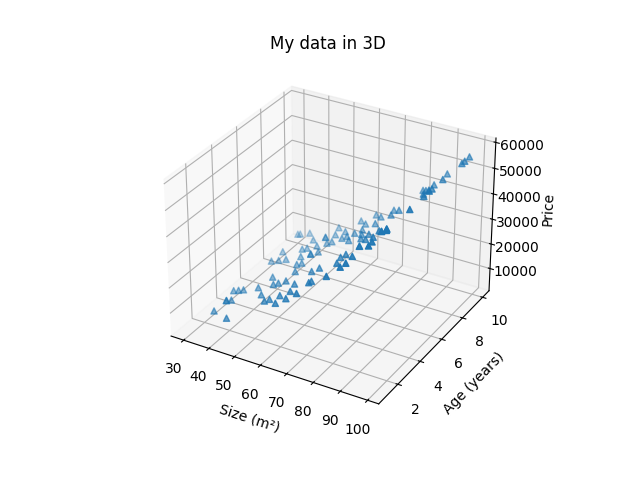

In [9]:
""" 
If we can visualize the data then it will be easier to understand.

This function only can visualize the data in 3D plot using 3 columns
"""
def visualizeIn3D(df):
    if df.shape[1] != 3:
        return # can not show
        
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    ax.set_title('My data in 3D')
    ax.set_xlabel(df.columns[0])
    ax.set_ylabel(df.columns[1])
    ax.set_zlabel(df.columns[2])

    ax.scatter(df.iloc[:,0],df.iloc[:,1],df.iloc[:,2], marker='^')
        
    #ax.legend()
    
    # in 3D, use mouse to click (empty area) and drag to change viewing point
    
    # important to block and to display plot properly (avoid black empty window in Linux or Jupyter Notebook)
    plt.show()#block=True) # code will continue after the window is closed
    
visualizeIn3D(df)


In [15]:
# create model, use the flag use_polynomial to easily test result between Linear and Polynomial model
model, poly = create_model(df, use_polynomial = True)
if model is None:
    exit(-10)

### create_model(DataFrame, use_polynomial=True)
Create optimal Polynomial degree
***
Found optimal Polynomial degree = 2
Highest r2 score = 0.9999995816536991
***
***
Coefficients = [[1 47 6 -0 -10]]
Intercept = [-80]
***

***** Evaluate model using TRAINED data *****
R2 score = 0.9999996, [closer to 1.0 is better]
MeanAbsoluteError = 9.5, [close to 0.0 is better]
===== Outliers table =====
    target  predicted  mae  outlier
0    13958      13948   10        0
1    54227      54222    5        0
2     6813       6810    3        0
3    33938      33936    2        0
4    34028      34041   13        0
..     ...        ...  ...      ...
62   29726      29732    6        0
63   37156      37172   16        0
64    9612       9600   12        0
65   52926      52912   14        0
66   24152      24158    6        0

[67 rows x 4 columns]
***** end of evaluation using trained data *****

***** Evaluate model using UNSEEN TESTING data *****
R2 score = 0.9999996, [closer to 1.0 is better]

In [16]:
# prepare new data to predict
#data_str = "[[1,10],[1,30],[1,50]]"
data_str = "[[50,1],[50,5],[50,10]]"

# convert string to numpy.array
js = json.loads(data_str)
data_to_predict = np.array(js)
print(f"data to predict, shape: {data_to_predict.shape}")
print(data_to_predict)

if poly is not None:
    # apply the same transformation to the data to be predicted, to ensure the data is in the same form as learned data ('model')
    data_to_predict = poly.transform(data_to_predict)

# predict
result = model.predict(data_to_predict)

print(f"prediction result:")

# attempt to display number without 'e+' notation
np.set_printoptions(formatter={'float': '{:0.0f}'.format})

print(result)
######## end of demo ########

data to predict, shape: (3, 2)
[[50  1]
 [50  5]
 [50 10]]
prediction result:
[[14726]
 [14675]
 [14172]]
